# Import libraries

In [1]:
# - Import required Python modules
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
# - Import our custom code for importing data
import os,sys,inspect
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../code/mapping'))) 

import read_data as rd

# Read income, assets and taxation data

In [3]:
# - Read map and 2015 tax data
gdfMap = rd.read_WV_map()
dfIncome = rd.read_2015_income()
dfAssets = rd.read_2015_assets()

# - Read mappings between IDs and descriptors
(dfMap_WVid_name, dfMapWVid_geoID, dfMapICid, dfMapACid) = rd.read_2015_mappings()

/anaconda3/envs/py36_gis/lib/python3.6/site-packages/pandas/util/_decorators.py:177: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


`GeoPandas` is a package for interpreting and manipulating map geometry data, alongside other data about map locations. Here we have a variable `gdfMap`, containing the area boundaries for the Basel-Stadt Wohnviertel (suburbs). The function `rd.read_WV_map()` does all the hard work of locating the files and importing them. We can have a look at the data using the `.head()` method:

In [4]:
gdfMap.head()

,OBJID,OBJECTID,TXT,ZTXT,TYPE,geometry
0,17136,1,7,07,Bruderholz,"POLYGON ((2612555.909 1264547.542, 2612560.552..."
1,17139,2,6,06,Gundeldingen,"POLYGON ((2610887.105 1266551.468, 2610896.202..."
2,17142,3,5,05,St. Alban,"POLYGON ((2612941.971 1267023.045, 2613000.085..."
3,17145,4,4,04,Breite,"POLYGON ((2613683.78 1266891.09, 2613686.423 1..."
4,17148,5,8,08,Bachletten,"POLYGON ((2610560.968 1266791.31, 2610571.054 ..."


Likewise, the functions `rd.read_2015_income()` and `...assets()` import data for income, assets and taxation, broken down by Wohnviertel.

In [5]:
dfIncome.head()

,wohnviertel_id,Wohnviertel,incomeclass_id,Income class,num_declarations,total_income,total_income_tax
0,1,Altstadt Grossbasel,1,0 to 29'999,640,7257907,113268
1,1,Altstadt Grossbasel,2,30'000 to 59'999,271,12238573,1399279
2,1,Altstadt Grossbasel,3,60'000 to 89'999,245,18121653,2831659
3,1,Altstadt Grossbasel,4,90'000 to 119'999,149,15385085,2526420
4,1,Altstadt Grossbasel,5,more than 120'000,370,111343117,21030480


In [6]:
dfAssets.head()

,wohnviertel_id,Wohnviertel,assetclass_id,Asset class,num_declarations,total_assets,total_asset_tax
0,1,Altstadt Grossbasel,1,0 to 49'999,945,11427211,68
1,1,Altstadt Grossbasel,2,50'000 to 99'999,153,10863042,1148
2,1,Altstadt Grossbasel,3,100'000 to 299'999,197,35659740,59634
3,1,Altstadt Grossbasel,4,300'000 to 599'999,132,57970452,182471
4,1,Altstadt Grossbasel,5,more than 700'000,248,1584480288,8993661


These data frames have various IDs (`wohnviertel_id`, `incomeclass_id`, `assetclass_id`) which define enumerations. There are also data in CHF about total income and assests, tax, etc. The variables `dfMap...` specify how to relate various enumerations. Of particular importance is how to map between `wohnviertel_id` and `geo_worhnviertel_id` (which is the `OBJECTID` column in the map data above).

In [7]:
dfMapWVid_geoID.head()

,wohnviertel_id,geo_wohnviertel_id,Wohnviertel
0,1,7,Altstadt Grossbasel
1,2,6,Vorstaedte
2,3,8,Am Ring
3,4,4,Breite
4,5,3,St. Alban


# Combining taxation data and the map
Now that we know how to imoport the data, let's draw a map of income / taxation across Basel Stadt. We first need to compute the total income per Wohnviertel, since this is currently broken down by asset class. We do this by defining some simple index functions, which return the rows of `dfIncome` that correspond to particular Wohnviertel (`WV`) or income class (`IC`).

In [8]:
# - Get unique Wohnviertel IDs
vnWVIDs = pd.unique(dfIncome['wohnviertel_id'])

# - Get total income tax for each wohnviertel
def find_WV(wv_id):
    return dfIncome.wohnviertel_id.map(lambda i: i == wv_id)

def find_IC(ic_id):
    return dfIncome.incomeclass_id.map(lambda i: i == ic_id)

# - Compute totals for income for each WV
vfWVTotalIncome = [sum(dfIncome.loc[find_WV(id), 'total_income'])
                   for id in vnWVIDs]

Let's plot the total income per Wohnviertel to take a look at it.

Text(0.5,1,'Total income per Wohnviertel')

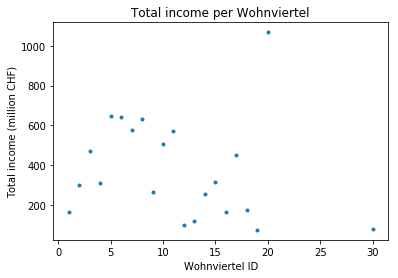

In [9]:
# - Make a plot of total income
plt.plot(vnWVIDs, np.array(vfWVTotalIncome) / 1e6, '.')
plt.xlabel('Wohnviertel ID')
plt.ylabel('Total income (million CHF)')
plt.title('Total income per Wohnviertel')

Woah, one Wohnviertel has a much higher total income than the others! Let's find out which one that is.

In [10]:
# - Find the WV with largest total income
nRichestWV = np.argmax(vfWVTotalIncome)

# - Map that to WV id
nRichestWVID = vnWVIDs[nRichestWV]

# - Find the name of that WV
dfMap_WVid_name[dfMap_WVid_name['wohnviertel_id'] == nRichestWVID]

,wohnviertel_id,wohnviertel_str
19,20,Riehen


Now lets map total income across Basel Stadt. `geopandas` data frames are smart, and know how to generate maps directly. First we need to combine the map data with the total income data we just calculated.

In [11]:
# - Make a new data frame containing income per WV
dfTotalIncome = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                              'total_income': np.asarray(vfWVTotalIncome) / 1e6})

# - Use the Map variable to relate WV id to geo WV id
dfTotalIncome = pd.merge(dfTotalIncome, dfMapWVid_geoID,
                         on = 'wohnviertel_id')

# - Merge this with the map data
gdfMap_BS_Income = pd.merge(gdfMap, dfTotalIncome, 
                            left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

Now we can produce a map using the `.plot()` method.

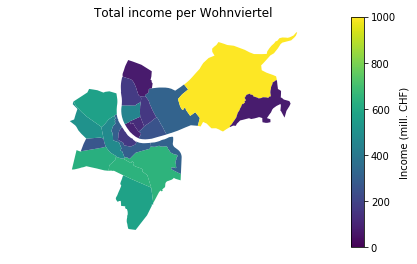

In [12]:
ax = gdfMap_BS_Income.plot(column = 'total_income', vmin = 0, vmax = 1000)
plt.title('Total income per Wohnviertel')
plt.axis('off')

# - Add a colour bar so the map is interpretable
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1000))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Income (mill. CHF)')


How about income *tax* per wohnviertel?

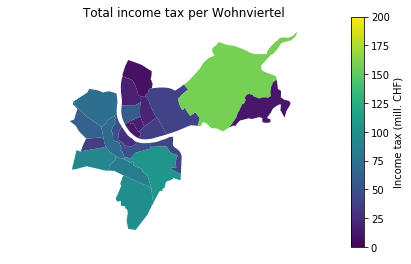

In [13]:
# - Compute totals for income tax for each WV and plot 
vfWVTotalIncomeTax = [sum(dfIncome.loc[find_WV(id), 'total_income_tax'])
                      for id in vnWVIDs]

# - Make a new data frame containing income taxper WV
dfTotalIncomeTax = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                                 'total_income_tax': np.asarray(vfWVTotalIncomeTax) / 1e6})

# - Use the Map variable to relate WV id to geo WV id
dfTotalIncomeTax = pd.merge(dfTotalIncomeTax, dfMapWVid_geoID,
                            on = 'wohnviertel_id')

# - Merge this with the map data
gdfMap_BS_IncomeTax = pd.merge(gdfMap, dfTotalIncomeTax, 
                               left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

# - Plot the map
ax = gdfMap_BS_IncomeTax.plot(column = 'total_income_tax', vmin = 0, vmax = 200)
plt.title('Total income tax per Wohnviertel')
plt.axis('off')

# - Add a colour bar so the map is interpretable
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=200))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Income tax (mill. CHF)')


# Breaking down income classes
It might be interesting to explore how the proportion of income tax breaks down per income bracket. Let's look at the proportion of income taxt paid by the lowest vs highest income bracket, per WV. We need to index the income data frame to locate income classes 1 (lowest) and 5 (highest) for each WV.

In [14]:
# - Define a function that locates 
def find_WV_IC(wv_id, ic_id):
    return find_WV(wv_id) & find_IC(ic_id)

# - Get percentage of total income tax for lowest income bracket
vfPrcIncomeTaxLowestBracket = [
    np.asscalar(dfIncome.loc[find_WV_IC(wv, 1), 'total_income_tax'] / tot) \
    for wv, tot in zip(vnWVIDs, vfWVTotalIncomeTax)
    ]

# - Get percentage of total income tax for highest income bracket
vfPrcIncomeTaxHighestBracket = [
    np.asscalar(dfIncome.loc[find_WV_IC(wv, 5), 'total_income_tax'] / tot) \
    for wv, tot in zip(vnWVIDs, vfWVTotalIncomeTax)
    ]

# - Get total number of declarations per bracket
vnNumDeclarationsBrackets = [
    np.sum(dfIncome.loc[find_IC(ic), 'num_declarations']) for ic in range(1, 6)
    ]

In [15]:
# - Construct data frames for tax proportions
dfPrcIncomeTax = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                               'prop_inc_tax_lowest': np.asarray(vfPrcIncomeTaxLowestBracket) * 100,
                               'prop_inc_tax_highest': np.asarray(vfPrcIncomeTaxHighestBracket) * 100})

dfPrcIncomeTax = pd.merge(dfPrcIncomeTax, dfMapWVid_geoID,
                          on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapTax = pd.merge(gdfMap, dfPrcIncomeTax,
                     left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

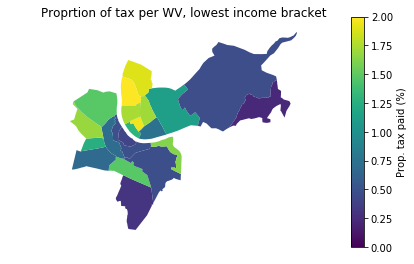

In [16]:
# - Plot maps of proportion of income tax paid by respective brackets
ax = gdfMapTax.plot(column = 'prop_inc_tax_lowest', vmin = 0, vmax = 2)
plt.axis('off')
plt.title('Proprtion of tax per WV, lowest income bracket')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=2))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Prop. tax paid (%)')


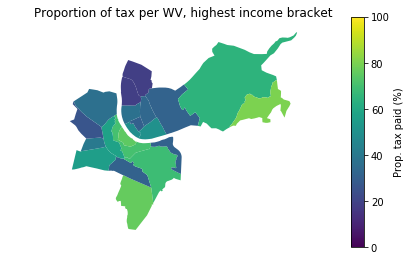

In [17]:
# - Plot maps of proportion of income tax paid by respective brackets
ax = gdfMapTax.plot(column = 'prop_inc_tax_highest', vmin = 0, vmax = 100)
plt.axis('off')
plt.title('Proportion of tax per WV, highest income bracket')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=100))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Prop. tax paid (%)')


# Equality metrics
One very common metric for quantifying inequality in an income distribution is called the *Gini* coefficient. From [wikipedia](https://en.wikipedia.org/wiki/Gini_coefficient#Discrete_probability_distribution):

For a discrete probability distribution with probability mass function $f(y_i)$, $i = 1 \textrm{ to } n$, where $f(y_i)$ is the fraction of the population with income or wealth $y_i >0$, the Gini coefficient is:
$$G={\frac {1}{2\mu }}\sum \limits _{i=1}^{n}\sum \limits _{j=1}^{n}\,f(y_{i})f(y_{j})|y_{i}-y_{j}|$$
where
$$\mu =\sum \limits _{i=1}^{n}y_{i}f(y_{i})$$

If the points with nonzero probabilities are indexed in increasing order ($y_i < y_{i+1}$) then:

$$G=1-{\frac {\Sigma _{i=1}^{n}\;f(y_{i})(S_{i-1}+S_{i})}{S_{n}}}$$
where
$S_{i}=\Sigma _{j=1}^{i}\;f(y_{j})\,y_{j}\,$ and $S_{0}=0\,$. These formulae are also applicable in the limit as $n\rightarrow \infty$.

Let's define a function `gini()`, which takes a list of population sizes in income classes, along with the minimum bound of each income class, and returns the *Gini* coefficient.

In [18]:
# - Define a function that calculates the Gini coefficient for a discrete distribution
def gini(vnPopClasses, vfClassTotalIncome):
    vfF_yi = np.array(vnPopClasses) / np.sum(vnPopClasses)
    vfyi = np.array(vfClassTotalIncome)
    vfSi = np.cumsum(vfyi * vfF_yi)
    
    fGini = 1-np.sum(vfF_yi[1:] * (vfSi[:-1] + vfSi[1:]) / vfSi[-1])
    
    return fGini

For a maximally equal distribution of incomes (or whatever measure), the Gini will be close to zero. For a maximally unequal distribution (one persion with all the wealth), the Gini will be close to one.

In [19]:
# - Equal distribution
print('Equal distribution: ', gini(np.ones(100), np.ones(100)))

# - Unequal distribution
print('Unequal distribution: ', gini(np.ones(100), np.concatenate(([0] * 99, [1]))))

Equal distribution:  0.00010000000000010001
Unequal distribution:  0.99


Now lets compute the Gini for income, assets, income tax.

In [26]:
# - Compute Gini for each Wohnviertel income distribution
vfGini_Income = [gini(dfIncome.loc[find_WV(nWV), 'num_declarations'], dfIncome.loc[find_WV(nWV), 'total_income']) for nWV in vnWVIDs]
vfGini_Assets = [gini(dfAssets.loc[find_WV(nWV), 'num_declarations'], dfAssets.loc[find_WV(nWV), 'total_assets']) for nWV in vnWVIDs]
vfGini_IncomeTax = [gini(dfIncome.loc[find_WV(nWV), 'num_declarations'], dfIncome.loc[find_WV(nWV), 'total_income_tax']) for nWV in vnWVIDs]
vfGini_AssetTax = [gini(dfAssets.loc[find_WV(nWV), 'num_declarations'], dfAssets.loc[find_WV(nWV), 'total_asset_tax']) for nWV in vnWVIDs]

In [27]:
# - Map gini for income and assets

# - Construct data frames for income Gini
dfGini = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                       'gini_income': np.asarray(vfGini_Income),
                       'gini_assets': np.asarray(vfGini_Assets),
                       'gini_income_tax': np.asarray(vfGini_IncomeTax),
                       'gini_asset_tax': np.asarray(vfGini_AssetTax)
                      })

dfGini = pd.merge(dfGini, dfMapWVid_geoID,
                  on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapGini = pd.merge(gdfMap, dfGini,
                      left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

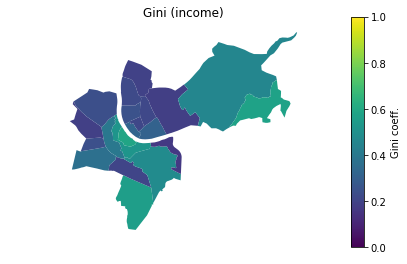

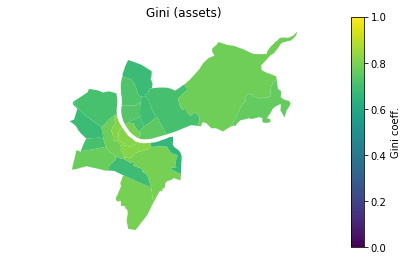

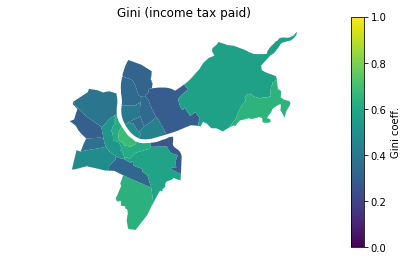

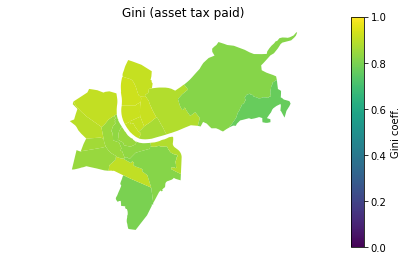

In [28]:
ax = gdfMapGini.plot(column = 'gini_income', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (income)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

ax = gdfMapGini.plot(column = 'gini_assets', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (assets)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

ax = gdfMapGini.plot(column = 'gini_income_tax', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (income tax paid)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

ax = gdfMapGini.plot(column = 'gini_asset_tax', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (asset tax paid)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

Text(0,0.5,'Asset tax Gini')

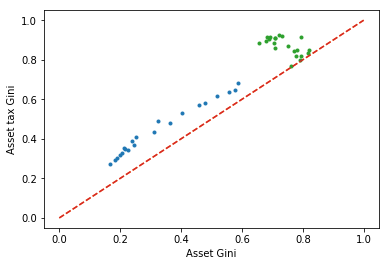

In [38]:
plt.plot(vfGini_Income, vfGini_IncomeTax, '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Income Gini')
plt.ylabel('Income tax Gini')

plt.plot(vfGini_Assets, vfGini_AssetTax, '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Asset Gini')
plt.ylabel('Asset tax Gini')